# Patient Administrative Outcomes Predictive Model

# 00. Setup Development Environment 

- Install Poetry to simplify dependency management. 
    - `pip install poetry` 
- Setup Poetery Project 
    - `poetry init` 
- Create a virtual envrionment 
    - `python -m venv .venv` 
- Add dependencies 
    - `poetry add pyspark ipykernel pandas matplotlib ploty seaborn`


In [3]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

import warnings
warnings.filterwarnings('ignore')

# 01. Data Integration

<!-- Data integration with Fast Healthcare Interoperability Resources (FHIR) resources involves unifying healthcare data from multiple systems to enable seamless data exchange and interoperability. This approach enhances data consistency, accessibility, and streamlines access to critical healthcare information across applications and organizations.

**Data Source: MIMIC-IV on FHIR**

The project uses MIMIC-IV on FHIR as its primary data source. This dataset provides a rich, de-identified healthcare database mapped to the FHIR (Fast Healthcare Interoperability Resources) standard to support interoperability and advanced analytics in healthcare research.

MIMIC-IV on FHIR is a project by PhysioNet designed to translate the structure and content of MIMIC-IV into the FHIR standard. MIMIC-IV is a relational database containing real hospital stay data for patients admitted to a tertiary academic medical center in Boston, MA, USA. It includes comprehensive clinical and administrative information recorded between 2008 and 2019.

By leveraging MIMIC-IV on FHIR, this project aims to enhance data interoperability and enable the development of predictive models and analytical insights aligned with modern healthcare standards and regulatory compliance.

**Fast Healthcare Interoperability Resources (FHIR)**

FHIR is a specification for exchanging health care data across different systems and platforms. The specification builds on and adapts modern, widely used RESTful practices to enable the provision of integrated healthcare across a wide range of teams and organizations. FHIR is based on "Resources" which are the common building blocks for all exchanges.

Key FHIR Resources for Integration:

- Patient: Stores demographic information such as name, age, and contact details.
- Encounter: Captures details of patient visits and interactions with healthcare providers.
- Condition: Represents diagnoses and health conditions affecting the patient.
- Procedure: Records medical procedures and interventions performed.
- Observation: Contains lab results, vital signs, and other clinical observations.

**Medallion Architecture**

The project follows a Medallion Architecture framework, which organizes data into multiple layers to ensure structured data refinement, improved data quality, and optimized analytics. This approach enhances data governance and enables efficient processing for downstream use cases.

The architecture comprises three key layers:
1. Bronze Layer (Raw Data): The Bronze layer stores raw, ingested data from various source systems without transformations. It retains all original fields and formats, providing a comprehensive source of truth for historical and traceability purposes.

2. Silver Layer (Filtered, Cleaned, Augmented): The Silver layer refines and transforms the raw data, selecting only the necessary fields from relevant FHIR resources (e.g., Patient, Encounter, Condition, Procedure). This layer provides clean, structured, and domain-specific datasets for targeted analysis and processing.

3. Gold Layer (Business-Level Aggregrates): The Gold layer aggregates data into a unified, optimized format for advanced analytics and reporting. In this project, it focuses on a Consolidated Encounter Table, combining encounter data with relevant patient demographics, conditions, and other clinical information to support predictive modeling and operational insights.

This layered architecture promotes scalability, data quality, and efficient data retrieval, aligning with best practices for healthcare data management and analytics.

> **References**
> - [MIMIC Implementatoin Guide | KinD Lab](https://mimic.mit.edu/fhir/)
> - [FHIR Documentation | HL7FHIR](https://www.hl7.org/fhir/)
> - [Medallion Architecture | Databricks](https://www.databricks.com/glossary/medallion-architecture) -->

In [4]:
spark = SparkSession.builder \
    .appName("FhirDataApplication") \
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.5.2") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.local", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.local.type", "hadoop") \
    .config("spark.sql.catalog.local.warehouse", "dataset/iceberg") \
    .getOrCreate()

## Bronze Layer

<!-- The Bronze Layer serves as the foundation of the data architecture, capturing raw, untransformed data from various source systems. It retains all original fields and formats, providing a comprehensive source of truth for historical and traceability purposes. This layer plays a crucial role in maintaining data integrity, enabling auditability, and supporting complex analytical workflows in later stages.

In the project, `bronze.resource` serves as a storage for raw data that has been ingested from various source files. -->

In [ ]:
with open("sql_queries/bronze.resource.ddl.sql") as f:
    spark.sql(f.read())

In [ ]:
RESOURCE_FILES = ["MimicPatient.ndjson.gz", "MimicCondition.ndjson.gz", "MimicConditionED.ndjson.gz", "MimicEncounter.ndjson.gz", "MimicEncounterED.ndjson.gz", "MimicEncounterICU.ndjson.gz"] 
for resource_file in RESOURCE_FILES: 
    resource_df = spark.read.text(f"dataset/{resource_file}") 
    resource_df = resource_df.withColumn("sourceFile", F.lit(resource_file)) 
    resource_df.write.format("iceberg").mode("append").save("local.bronze.resource")

In [ ]:
print("Data Volume in Each File")
data_volume_df = spark.sql("select sourceFile, count(*) cnt from  local.bronze.resource group by 1").toPandas()

In [ ]:
plt.figure(figsize=(20, 8))
bars = plt.bar(data_volume_df['sourceFile'], data_volume_df['cnt'])

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart with Full Number Labels')

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        bar.get_height(),                   # Y position
        f'{bar.get_height():,}',            # Format with commas
        ha='center', va='bottom', fontsize=10  # Center alignment, font size
    )

## Silver Layer

<!-- The Silver Table represents the refined data layer in the Medallion Architecture, where raw data from the Bronze Layer is transformed and cleansed. It focuses on structuring the data and selecting only the necessary fields from relevant sources, ensuring that it is ready for more detailed analysis and reporting.

The Silver Tables in use include Patient, Encounter, and Condition. The Patient table stores essential demographic information, while the Encounter table tracks patient visits and interactions with healthcare providers. The Condition table holds information about patient diagnoses and health conditions.

The resources are stored while adhering to Safe Harbor provisions to ensure patient privacy and compliance with data protection regulations.

**Safe Harbor Provisions**

Safe Harbor provisions are a set of guidelines that allow organizations to de-identify personal data in a way that ensures compliance with privacy regulations, particularly in the context of healthcare and data protection laws like HIPAA. Under these provisions, data can be stripped of specific identifiers, such as names, addresses, and Social Security numbers, making it no longer considered protected health information (PHI). Safe Harbor provisions offer a balance between privacy protection and the need for data availability, enabling the use of anonymized data while minimizing the risk of re-identification.


> **References**
> - [Guidance Regarding Methods for De-identification of PHI](https://www.hhs.gov/hipaa/for-professionals/special-topics/de-identification/index.html) -->

In [ ]:
# Load Bronze Table
raw_df = spark.read.format("iceberg").load("local.bronze.resource")

### Patient Mart

<!-- The Patient Mart stores essential demographic information for each patient, providing a foundational set of details necessary for understanding patient profiles and is used in various healthcare processes, from clinical interactions to research and analysis.

| Column Name   | Description                                   |
|---------------|-----------------------------------------------|
| patientID     | A unique identifier assigned to each patient. |
| gender        | The patient's gender (e.g., male or female).  |
| birthDate     | The patient's date of birth.                  |
| maritalStatus | The marital status of the patient.            | -->

In [ ]:
with open("sql_queries/silver.patient.ddl.sql") as f:
    spark.sql(f.read())

In [ ]:
patient_df = raw_df.filter(raw_df.sourceFile.isin("MimicPatient.ndjson.gz"))
with open("schema/Patient.json") as f:
    schema_read = json.loads(f.read())
schema = T.StructType.fromJson(schema_read)
patient_df = patient_df.withColumn("parsed_json", F.from_json(patient_df["value"], schema))
patient_df = patient_df.select("parsed_json.*", "sourceFile")
patient_df.createOrReplaceTempView("patient_df")

with open("sql_queries/silver.patient.load.sql") as f:
    fm_patient = spark.sql(f.read())

fm_patient.show(5, truncate=False)
fm_patient.write.format("iceberg").mode("overwrite").save("local.silver.patient")

### Encounter Mart

<!-- The Encounter resource represents an interaction between a patient and healthcare provider(s) for the purpose of delivering healthcare services or assessing the patient’s health status.

It captures the full span of a hospital stay, from admission to discharge, and includes important details such as the start and end time of the admission, the context surrounding the admission, and patient movements within the healthcare facility.

| Column            | Description                                                                                                                          |
|-------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| encounterId       | A unique identifier for the encounter.                                                                                               |
| patientId         | A unique identifier for the patient involved in the encounter.                                                                       |
| ref_encounterId   | A reference to a related encounter, which may relate to both future and past encounters.                                             |
| periodStart       | The start timestamp marking the beginning of the encounter period.                                                                   |
| periodEnd         | The end timestamp marking the conclusion of the encounter period.                                                                    |
| duration          | The total duration of the encounter, typically in hours or days.                                                                     |
| status            | The current status of the encounter (e.g., planned, in-progress, finished).                                                          |
| encounterClass    | The classification of the encounter, such as inpatient or outpatient, helping to categorize the type of healthcare service provided. |
| codedType         | A code representing the specific type of encounter, aiding in standardized classification.                                           |
| displayType       | A human-readable display name for the type of encounter.                                                                             |
| systemType        | The system from which the encounter type code is derived.                                                                            |
| priority          | The urgency level of the encounter, which may include options like routine, urgent, or emergency.                                    |
| nextEncounterId   | A reference to next encounter                                                                                                        |
| readmissionStatus | Future readmission indicator                                                                                                         | -->

In [ ]:
with open("sql_queries/silver.encounter.ddl.sql") as f:
    spark.sql(f.read())

In [ ]:
encounter_df = raw_df.filter(raw_df.sourceFile.isin("MimicEncounter.ndjson.gz", "MimicEncounterED.ndjson.gz")) 
with open("schema/Encounter.json") as f: 
    schema_read = json.loads(f.read()) 
schema = T.StructType.fromJson(schema_read) 
encounter_df = encounter_df.withColumn("parsed_json", F.from_json(encounter_df["value"], schema)) 
encounter_df = encounter_df.select("parsed_json.*", "sourceFile") 
encounter_df.createOrReplaceTempView("encounter_df") 

with open("sql_queries/silver.encounter.load.sql") as f:
    fm_encounter = spark.sql(f.read())

fm_encounter.show(5, truncate=False) 
fm_encounter.write.format("iceberg").mode("overwrite").save("local.silver.encounter")

### Condition Mart

<!-- The Condition resource in FHIR is used to document a patient’s health state, including diagnoses, clinical problems, or other health concerns.

It captures conditions that are significant enough to warrant clinical focus, including diseases, health problems, or the state following a medical procedure.

This resource plays a critical role in capturing a patient’s health history and providing a detailed record of conditions for clinical decision-making, research, and care management.

| Column           | Description                                                                                 |
|------------------|---------------------------------------------------------------------------------------------|
| conditionId      | A unique identifier for the condition.                                                      |
| patientId        | A unique identifier for the patient associated with the condition.                          |
| encounterId      | The unique identifier for the encounter where the condition was diagnosed or recorded.      |
| categoryCode     | A code representing the category of the condition (e.g., diagnosis, problem).               |
| conditionCode    | The code that represents the specific condition, typically from a standardized code system. |
| conditionDisplay | A human-readable display name for the condition.                                            |
| conditionSystem  | The system from which the condition code is derived (e.g., ICD-10, SNOMED CT).              | -->

In [ ]:
with open("sql_queries/silver.condition.ddl.sql") as f:
    spark.sql(f.read())

In [ ]:
condition_df = raw_df.filter(raw_df.sourceFile.isin("MimicCondition.ndjson.gz", "MimicConditionED.ndjson.gz")) 
with open("schema/Condition.json") as f: 
    schema_read = json.loads(f.read()) 
schema = T.StructType.fromJson(schema_read) 
condition_df = condition_df.withColumn("parsed_json", F.from_json(condition_df["value"], schema)) 
condition_df = condition_df.select("parsed_json.*", "sourceFile") 
condition_df.createOrReplaceTempView("condition_df") 

with open("sql_queries/silver.condition.load.sql") as f:
    fm_condition = spark.sql(f.read())

fm_condition.show(5, truncate=False) 
fm_condition.write.format("iceberg").mode("overwrite").save("local.silver.condition")

# 02. Data Exploration

In [3]:
# !pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Patient Dataset

In [ ]:
px.line(
    spark.sql("select date_format(birthDate, 'yyyy') birthYear, count(*) count from local.silver.patient group by 1 order by 1").toPandas(),
    x='birthYear',
    y='count',
    title='Patient BirthYear Distribution [De-Identified]'
).update_layout(
    xaxis_title='Birth Year',
    yaxis_title='Number of Patients',
    template='plotly_white'
).show()

In [ ]:
px.pie(
    spark.sql("select gender, count(*) count from local.silver.patient group by 1 order by 1").toPandas(),
    values='count', names='gender', title='Gender Distribution'
).show()

In [ ]:
px.bar( 
    spark.sql("select gender, maritalStatus, count(*) count from local.silver.patient group by 1,2").toPandas(), 
    x='maritalStatus', 
    y='count', 
    color='gender', 
    title='Count by Gender and Marital Status', 
    barmode='group' 
).show()

## Encounter Dataset

In [ ]:
px.line(
    spark.sql("""
    select date_format(periodStart, 'yyyy') encounterYear, count(*) count from local.silver.encounter group by 1 order by 1
    """).toPandas(),
    x='encounterYear',
    y='count',
    title='Encounter Period Year Distribution [De-Identified]'
).update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Encounters',
    template='plotly_white'
).show()

In [ ]:
px.pie(
    spark.sql("select sourceFile, count(*) count from local.silver.encounter group by 1").toPandas(),
values='count', names='sourceFile', title='Source Distribution').show()

In [ ]:
px.pie(
    spark.sql("select encounterClass, count(*) count from local.silver.encounter group by 1").toPandas(),
values='count', names='encounterClass', title='Encounter Class Distribution').show()

In [ ]:
px.pie(
    spark.sql("select priority, count(*) count from local.silver.encounter group by 1").toPandas(),
values='count', names='priority', title='Encounter Class by Priority').show()

In [ ]:
px.pie(
    spark.sql("select readmissionStatus, count(*) count from local.silver.encounter group by 1").toPandas(),
values='count', names='readmissionStatus', title='Patient Readmission').show()

In [ ]:
px.line(
    spark.sql("""select readmissionStatus, year(periodStart) year, count(*) count
    from local.silver.encounter group by 1,2 order by 2""").toPandas(),
    x='year',
    y='count',
    color='readmissionStatus', # Differentiate lines by readmissionStatus
    title='Encounter Over the Years by ReadmissionStatus',
    labels={'year': 'Year', 'count': 'Number of Encounters'}).update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Encounters',
    legend_title='Readmission Status',
    template='plotly_white'
).show()

In [ ]:
priority_encounter_df = spark.sql("""
SELECT
    e1.priority priority1,
    e2.priority priority2,
    count(*) count
FROM local.silver.encounter e1
JOIN local.silver.encounter e2
ON e1.nextEncounterId = e2.encounterID
WHERE e1.readmissionStatus == 'Readmission'
GROUP BY all
ORDER by 3 desc
""")

priority_encounter_pd = priority_encounter_df.toPandas()
all_priorities = list(set(priority_encounter_pd['priority1'].tolist() +
                          priority_encounter_pd['priority2'].tolist()))
node_map = {priority: idx for idx, priority in enumerate(all_priorities)}
priority_encounter_pd['source'] = priority_encounter_pd['priority1'].map(node_map)
priority_encounter_pd['target'] = priority_encounter_pd['priority2'].map(node_map)

table_trace = go.Table(
    header=dict(values=["Priority 1", "Priority 2", "Count"], fill_color='lightgrey', align='center'),
    cells=dict(values=[priority_encounter_pd['priority1'], priority_encounter_pd['priority2'], priority_encounter_pd['count']],
               fill_color='white', align='center')
)

sankey_trace = go.Sankey(
    node=dict(
        pad=15, # Padding between nodes
        thickness=20, # Node thickness
        line=dict(color="black", width=0.5), # Node border settings
        label=all_priorities # Node labels
    ),
    link=dict(
        source=priority_encounter_pd['source'], # Source nodes (indices)
        target=priority_encounter_pd['target'], # Target nodes (indices)
        value=priority_encounter_pd['count'] # Flow values (counts)
    )
)

fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.7, 0.3], # Adjust column widths (30% table, 70% Sankey)
    specs=[[{"type": "table"}, {"type": "sankey"}]], # Specify types for each subplot
)


fig.add_trace(sankey_trace, row=1, col=1)
fig.add_trace(table_trace, row=1, col=2)

fig.update_layout(
    title_text="Readmission Encounters: Priority Transitions Sankey Diagram and Table",
    font_size=12,
    height=500
)
fig.show()

In [ ]:
spark.sql("""
SELECT
    sourceFile,
    CASE
        WHEN duration BETWEEN 0 AND 5 THEN '0 to 5 days'
        WHEN duration BETWEEN 6 AND 10 THEN '6 to 10 days'
        WHEN duration BETWEEN 11 AND 20 THEN '11 to 20 days'
        WHEN duration BETWEEN 21 AND 30 THEN '21 to 30 days'
        WHEN duration BETWEEN 31 AND 50 THEN '31 to 50 days'
        WHEN duration BETWEEN 51 AND 100 THEN '51 to 100 days'
        WHEN duration BETWEEN 101 AND 150 THEN '101 to 150 days'
        WHEN duration BETWEEN 151 AND 200 THEN '151 to 200 days'
        WHEN duration BETWEEN 201 AND 250 THEN '201 to 250 days'
        WHEN duration BETWEEN 251 AND 300 THEN '251 to 300 days'
        ELSE 'More than 300 days'
    END AS duration_group,
    COUNT(*) AS encounter_count
FROM local.silver.encounter
GROUP BY sourceFile, duration_group
ORDER BY sourceFile, double(split_part(duration_group, ' ', 1));
""").show(50, truncate = False)

In [ ]:
px.line(
    spark.sql("""SELECT
        sourceFile,
        duration AS duration_group,
        COUNT(*) AS encounter_count
    FROM local.silver.encounter
    where duration BETWEEN 1 AND 30
    GROUP BY sourceFile, duration_group
    ORDER BY sourceFile, duration_group;""").toPandas(),
    x='duration_group', y='encounter_count', color='sourceFile',
    markers=True, title="Encounter Count by Source and Duration Group").show()

## Condition Dataset

In [ ]:
px.pie(
    spark.sql("select split_part(conditionSystem, '/', -1) conditionSystem, count(*) count from local.silver.condition group by 1").toPandas(),
    values='count', names='conditionSystem', title='Condition System Count Distribution').show()

Based on the `Condition System Count Distribution` chart, the dataset incorporates both ICD-9 and ICD-10 coding systems in condition table.

<!-- The difference between these two coding systems can introduce challenges which may affect the model performance and interpretability.

1. Inconsistent Coding:
    - ICD-10 has more granularity in specifying types of diseases, injury location, and severity.
    - ICD-9 has fewer and less specific codes than ICD-10, which means that a single ICD-9 code could map to multiple ICD-10 codes.
    - This inconsistency can create noisy features in your dataset if the same condition is coded differently depending on the coding system used. This could confuse your model, leading to reduced predictive accuracy.
2. Feature Engineering Complexity:
    - ICD-9 and ICD-10 are structured differently, both in terms of the number of codes and their specificity.
    - This complicates the creation of features related to diagnosis categories or comorbidities.
    - The features might not capture the full clinical picture, potentially leading to underfitting or overfitting
3. Data Heterogeneity:
    - Introduction of temporal bias into the model
    - This could cause the model to overestimate or underestimate readmission risks if it correlates newer coding systems with better or worse outcomes.
4. Model Interpretability:
    - Mixed coding systems make model interpretation harder, especially if using interpretable models like decision trees or logistic regression.
    - This may end up with features that are not comparable between ICD-9 and ICD-10, complicating efforts to explain your model's predictions.

> **References**
> - [Understanding the Impact of the Differences in ICD-9-CM and ICD10-CM and Its Potential Impact on Data Analysis | National Center for Health Statistics](https://www.cdc.gov/nchs/ppt/nchs2012/li-01_pickett.pdf)
> - [Overview of Coding and Classification Systems](https://www.cms.gov/cms-guide-medical-technology-companies-and-other-interested-parties/coding/overview-coding-classification-systems) -->

In [ ]:
spark.sql("""
select conditionCode, conditionDisplay, count(*) count from local.silver.condition
where conditionSystem like '%mimic-diagnosis-icd10'
group by all order by 3 desc
""").show(10, truncate = False)

In [ ]:
spark.sql("""
select conditionCode, conditionDisplay, count(*) count from local.silver.condition
where conditionSystem like '%mimic-diagnosis-icd9'
group by all order by 3 desc
""").show(10, truncate = False)

Comparing top condition for both coding systems, there are few notable common types between them.

For Example:

- ICD 9 Code 4019 `Unspecified essential hypertension` is similar to ICD 10 Code I10 `Essential (primary) hypertension`.
- ICD 9 Code V1582 `Personal history of tobacco use` is similar to ICD 10 Code Z87891 `Personal history of nicotine dependence`.
- ICD 9 Code 2724 `Other and unspecified hyperlipidemia ` is similar to ICD 10 Code E785 `Hyperlipidemia, unspecified`.

The dataset must be standardized in order to gain better accuracy of predictive model.

# 03. Data Modeling

## Condition Domain

### Standardarize Coding System

<!-- The dataset, as shown in the Condition System Count Distribution chart, includes both ICD-9 and ICD-10 coding systems in the condition table.

To standardize the dataset, one approach is to map ICD-9 codes to their ICD-10 equivalents using tools like General Equivalence Mappings (GEMs).

This conversion ensures consistency across the dataset by aligning all condition codes with the ICD-10 system, which is the current standard for coding medical diagnoses and procedures.

**ICD-10 Code Structure**
- Characters 1:3 = Indicate the category of the diagnosis
- Characters 4:6 = Indicate etiology, anatomic site, severity or other clinical detail
- Character 7 = Extension

> **References**
> - [Crosswalk or General Equivalence Mappings | NBER](https://www.nber.org/research/data/icd-9-cm-and-icd-10-cm-and-icd-10-pcs-crosswalk-or-general-equivalence-mappings) -->


In [ ]:
with open("sql_queries/silver.condition-standard.ddl.sql") as f:
    spark.sql(f.read())

In [6]:
df = spark.read.csv("dataset/icd9toicd10cmgem.csv", header = True) 
df.createOrReplaceTempView("GemMapping") 

with open("sql_queries/silver.condition-standard.load.sql") as f:
    icd9_df = spark.sql(f.read())

icd9_df.write.format("iceberg").mode("append").save("local.silver.condition_standard")

In [ ]:
spark.sql(""" 
select 
    conditionID, encounterID, patientID, 
    conditionCode 
from local.silver.condition_standard 
""").show(10, truncate = False)

### Risk Categorization

<!-- **Risk categorization based on the Charlson Comorbidity Index (CCI)**

Risk categorization based on the Charlson Comorbidity Index (CCI) is a widely used method for assessing the risk of adverse outcomes in patients, particularly in healthcare settings. The CCI assigns weights to various comorbid conditions based on their severity, such as heart disease, diabetes, and cancer. These conditions are then summed to produce a total score, which can be used to predict patient outcomes, including the risk of mortality and complications. The higher the CCI score, the greater the patient’s risk. This index helps clinicians and healthcare providers identify high-risk patients, prioritize care, and make informed decisions regarding treatment plans, resource allocation, and follow-up care. It is an essential tool for improving patient outcomes and optimizing healthcare management.

| Condition                             | Weight | Risk Level |
|---------------------------------------|--------|------------|
| Peripheral vascular disease           | 1      | Low        |
| Cerebrovascular disease               | 1      | Low        |
| Chronic pulmonary disease             | 1      | Low        |
| Congestive heart failure              | 1      | Low        |
| Rheumatic disease                     | 1      | Low        |
| Diabetes without chronic complication | 1      | Low        |
| Mild liver disease                    | 1      | Low        |
| Peptic ulcer disease                  | 1      | Low        |
| Renal disease                         | 1      | Low        |
| Myocardial infarction                 | 2      | Moderate   |
| Hemiplegia or paraplegia              | 2      | Moderate   |
| Malignancy                            | 2      | Moderate   |
| Diabetes with chronic complication    | 2      | Moderate   |
| Moderate or severe liver disease      | 3      | High       |
| Metastatic solid tumour               | 6      | High       |
| AIDS/HIV                              | 6      | High       |

> **References**
> - [Charlson Comorbidity Index Calculator](https://www.mdcalc.com/calc/3917/charlson-comorbidity-index-cci)
> - [Calculation of the Charlson Comorbidity Index score](https://www.ncbi.nlm.nih.gov/books/NBK587905/)
> - [ICD-10-CM to CMS-HCC Crosswalk](https://provider.amerigroup.com/dam/publicdocuments/ALL_CARE_CMSHCCRAModel_mrdcoding_tips.pdf)
> - [CCI ICD-10 codes Mapping](https://www.psychiatryinvestigation.org/upload/media/pi-2021-0223-suppl1.pdf) -->

In [ ]:
with open("sql_queries/silver.condition-risk.ddl.sql") as f:
    spark.sql(f.read())

In [4]:
with open("sql_queries/silver.condition-risk.load.sql") as f:
    condition_risk_df = spark.sql(f.read())

condition_risk_df.write.format("iceberg").mode("overwrite").save("local.silver.condition_risk")

In [ ]:
spark.sql("select charlsonCategory, riskLevel, count(*) from local.silver.condition_risk group by 1,2").show(20, truncate = False)

### Case-Based Aggregation

In [ ]:
with open("sql_queries/silver.condition-rollup.ddl.sql") as f:
    spark.sql(f.read())

In [30]:
with open("sql_queries/silver.condition-rollup.load.sql") as f:
    condition_rollup_df = spark.sql(f.read())

condition_rollup_df.show(10, truncate = False)
condition_rollup_df.write.format("iceberg").mode("overwrite").save("local.silver.condition_rollup")

## Consolidated Encounter

<!-- The Gold Layer represents the refined stage in the Medallion Architecture, where data from the Silver Layer is consolidated and fully processed for advanced analytics and reporting. The Gold Table serves as the foundation for high-level analysis, enabling analysts, and researchers to derive meaningful insights that drive operational efficiency, improve patient outcomes, and support value-based care initiatives.

The Encounter Gold Table integrates and structures the most critical data points related to patient encounters, ensuring that it is clean, accurate, and ready for decision-making. The table has various data points (such as patient demographics, encounter details, clinical diagnoses) merged and aggregated into a comprehensive, easily accessible format.  -->

In [11]:
with open("sql_queries/gold.encounter.ddl.sql") as f:
    spark.sql(f.read())

In [12]:
with open("sql_queries/gold.encounter.load.sql") as f:
    gold_encounter_df = spark.sql(f.read())

gold_encounter_df.write.format("iceberg").mode("overwrite").save("local.gold.encounter")

# 04. Data Profiling

In [2]:
parquet_location = 'dataset/encounter.parquet'
# gold_encounter_df = spark.read.format("iceberg").load("local.gold.encounter").toPandas()
# gold_encounter_df.to_parquet(parquet_location)
gold_encounter_df = pd.read_parquet(parquet_location)

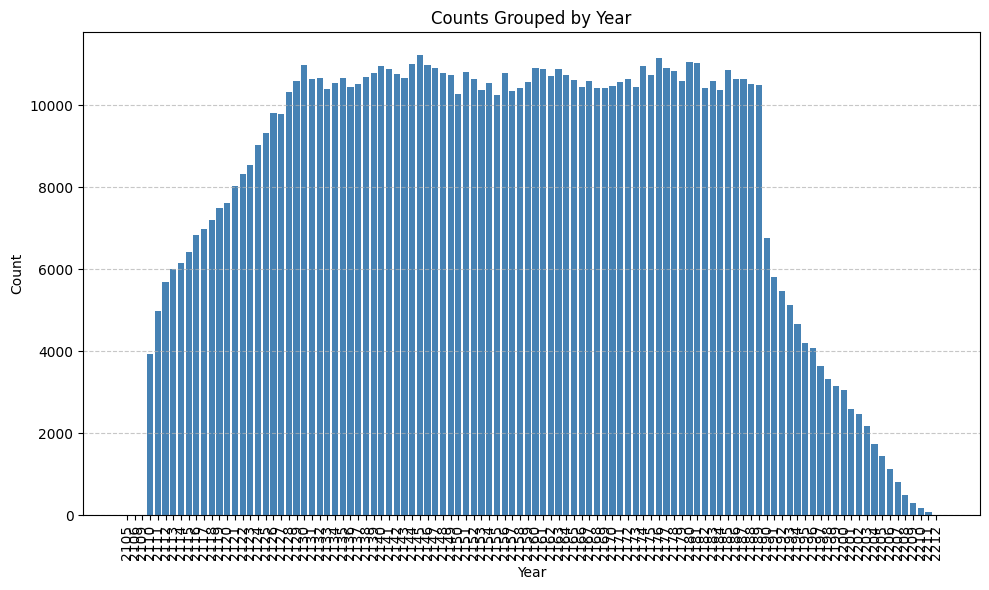

In [3]:
df = gold_encounter_df
df['year'] = pd.to_datetime(df['encounterTs']).dt.year
grouped_by_year = df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(grouped_by_year['year'].astype(str), grouped_by_year['count'], color='steelblue')
plt.title('Counts Grouped by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [4]:
# Convert columns to the category data type. 
cols_to_convert = ["gender", "ageGroup", "maritalStatus", "encounterStatus", "encounterClass", "admitSource", "encounterType", "priority", "readmissionStatus"]
for col in cols_to_convert:
    gold_encounter_df[col] = gold_encounter_df[col].astype('category')

non_features_columns = ['encounterId','patientId','encounterTs','encounterStatus', 'encounterType']
gold_encounter_df = gold_encounter_df.drop(non_features_columns, axis=1)

## DataFrame Summary

In [23]:
gold_encounter_df.info(verbose=False)
gold_encounter_df.describe()
s_datatype = pd.Series(gold_encounter_df.dtypes, name='DataType')
s_uniquecount = pd.Series(gold_encounter_df.nunique(), name='Unique Count')
s_count = pd.Series(gold_encounter_df.count(), name='Total Count')
s_nullcount = pd.Series(gold_encounter_df.isnull().sum(), name='Null Values')
report_df = pd.concat([s_datatype, s_uniquecount, s_count, s_nullcount], axis=1)
display(report_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856318 entries, 0 to 856317
Columns: 12 entries, gender to readmissionStatus
dtypes: category(7), int32(5)
memory usage: 22.1 MB


,DataType,Unique Count,Total Count,Null Values
gender,category,2,856318,0
ageGroup,category,9,856318,0
maritalStatus,category,5,856318,0
stayLength,int32,167,856318,0
encounterClass,category,4,856318,0
admitSource,category,16,856318,0
priority,category,4,856318,0
riskScore,int32,64,856318,0
highRiskCondition,int32,12,856318,0
moderateRiskCondition,int32,15,856318,0


## Imbalance Ratio

- An imbalance ratio of 1.54 is moderate and may still impact model performance.
- Possible Cause: Readmissions (the minority class) are typically less frequent than non-readmissions (the majority class)
- Impact of Class Imbalance: Bias toward Majority Class (Non-readmissions)

Measures to solve imbalance ratio:
- Undersampling the Majority Class: Remove some non-readmitted patients to balance the dataset. However, this may lead to the loss of useful information.
- Oversampling the Minority Class: Increase the readmitted patients to balance the dataset. Help the model learn better about the minority class and prevent it from being biased toward the majority class.

Imbalance Ratio: 1.54


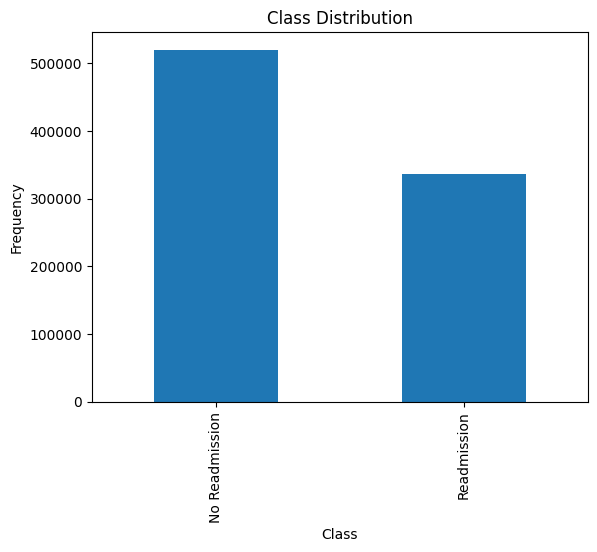

In [24]:
target_distribution = gold_encounter_df.groupby('readmissionStatus').size()
majority_class_count = target_distribution.max()
minority_class_count = target_distribution.min()
imbalance_ratio = majority_class_count/minority_class_count
print("Imbalance Ratio: {:.2f}".format(imbalance_ratio))

target_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.show()

# 05. Feature Exploration

### Readmission Status by Categorical Variables

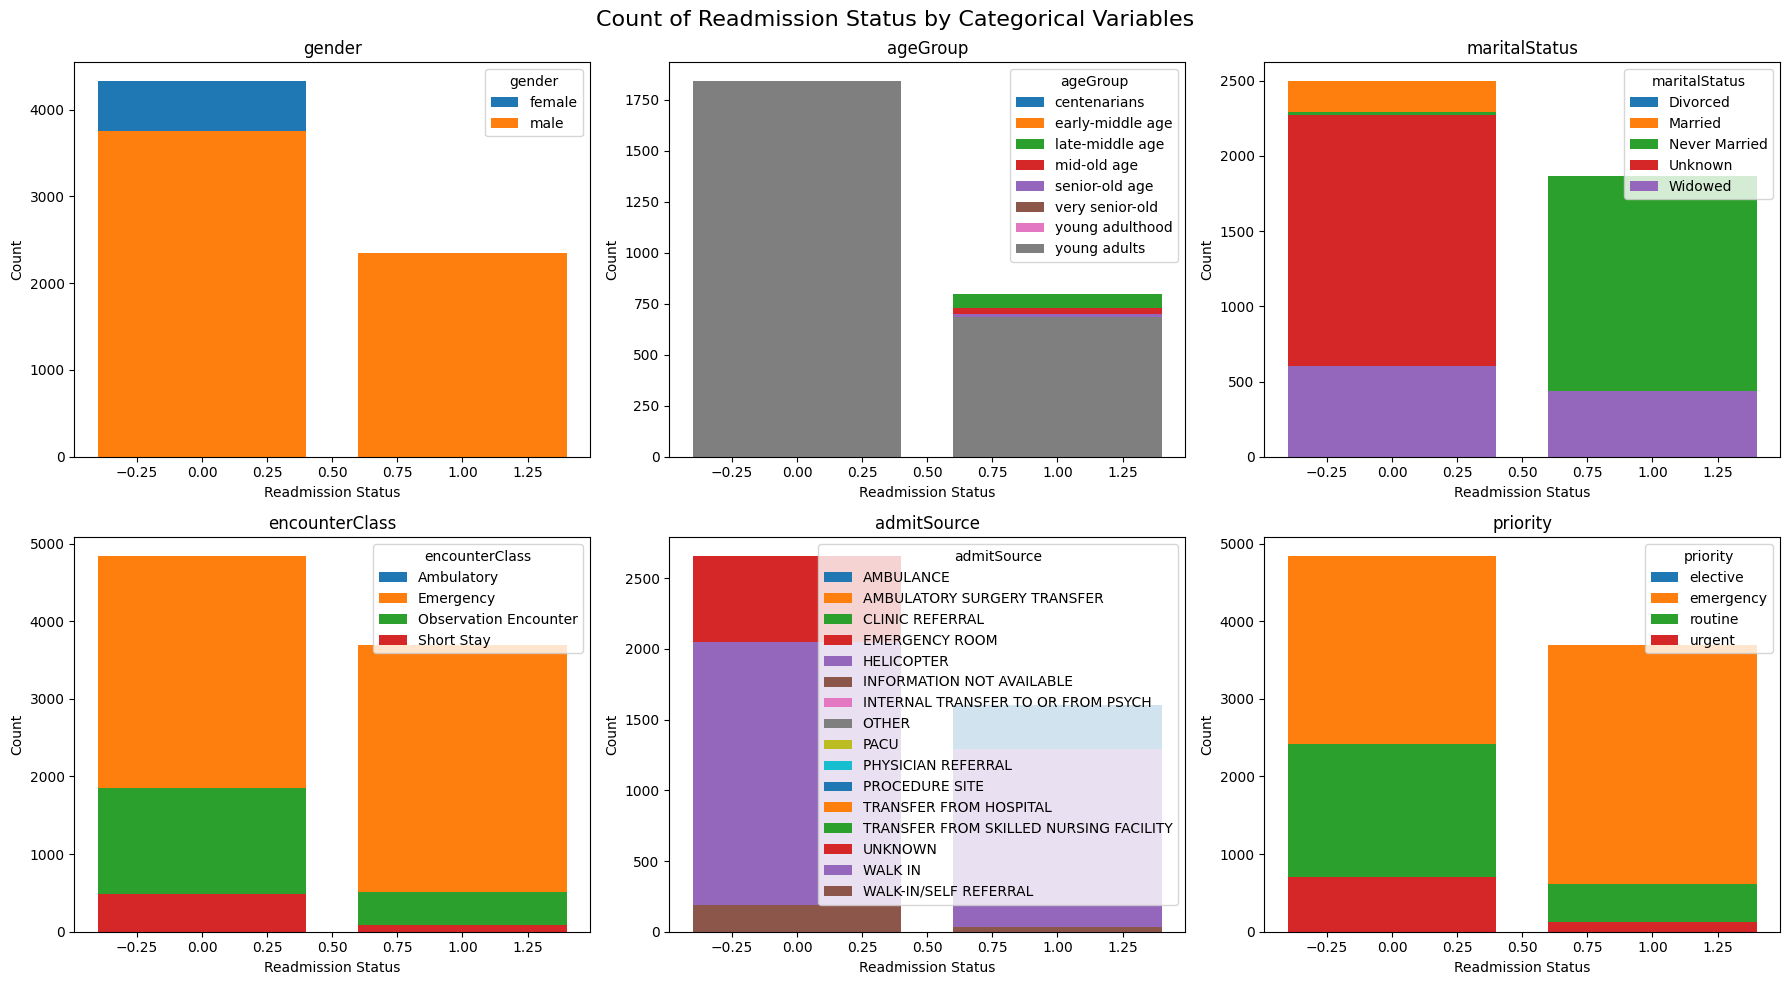

In [70]:
# Group by categorical variable and count occurrences
grouped_data = {}
for column in ['gender', 'ageGroup', 'maritalStatus', 'encounterClass', 'admitSource', 'priority']:
    grouped_data[column] = gold_encounter_df.groupby([column, 'readmissionStatus']).size().reset_index(name='counts')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Count of Readmission Status by Categorical Variables', fontsize=16)
for i, column in enumerate(grouped_data.keys()):
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index
    ax = axes[row, col]
    for category in grouped_data[column][column].unique():
        category_data = grouped_data[column][grouped_data[column][column] == category]
        ax.bar(category_data['readmissionStatus'], category_data['counts'], label=category)
    ax.set_xlabel('Readmission Status')
    ax.set_ylabel('Count')
    ax.set_title(f'{column}')
    ax.legend(title=column)

plt.tight_layout()
plt.show()

## Bar Chart Age Group Size

In [ ]:
df = gold_encounter_df
order = ['young adults' ,'young adulthood' ,'early-middle age' ,'late-middle age' ,'mid-old age' ,'senior-old age' ,'very senior-old' ,'centenarians' ] 

df['ageGroup'] = pd.Categorical(df['ageGroup'], categories=order, ordered=True)
grouped_df = df.groupby('ageGroup').size().reset_index(name='count')

plt.figure(figsize=(18, 6))
plt.bar(grouped_df['ageGroup'], grouped_df['count'])
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Count of Individuals by Age Group')
plt.show()

## Heatmap Risk Scores by Age Group And Rick Score Tens

In [ ]:
df = gold_encounter_df[gold_encounter_df['riskScore']> 0]
df['scoreTens'] = df['riskScore'] // 10 * 10

grouped_df = df.groupby(['ageGroup', 'scoreTens']).size().reset_index(name='count')

pivot_df = grouped_df.pivot_table(index='ageGroup', columns='scoreTens', values='count', fill_value=0)

plt.figure(figsize=(10, 8))
plt.imshow(pivot_df, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.xlabel('Risk Score Tens')
plt.ylabel('Age Group')
plt.title('Count of Risk Scores by Age Group and Risk Score Tens')
plt.colorbar()

for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        plt.text(j, i, str(pivot_df.values[i, j]), ha='center', va='center', color='w')

plt.show()

## Heatmap High/Low/Moderate Risk by Age Group

In [ ]:
conditions = ['highRiskCondition', 'moderateRiskCondition', 'lowRiskCondition']
titles = ['High Risk', 'Moderate Risk', 'Low Risk']

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for i, condition in enumerate(conditions):
    filtered_df = df[df[condition] > 0]
    filtered_df['scoreTens'] = filtered_df[condition]
    grouped_df = filtered_df.groupby(['ageGroup', 'scoreTens']).size().reset_index(name='count')
    pivot_df = grouped_df.pivot_table(index='ageGroup', columns='scoreTens', values='count', fill_value=0)

    axes[i].imshow(pivot_df, cmap='viridis', interpolation='nearest')
    axes[i].set_xticks(range(len(pivot_df.columns)), pivot_df.columns)
    axes[i].set_yticks(range(len(pivot_df.index)), pivot_df.index)
    axes[i].set_title(f'Count of {titles[i]} Scores by Age Group')
plt.tight_layout()
plt.show()

## Heatmap High Risk by Age Group (Detail View)

In [ ]:
df = gold_encounter_df[gold_encounter_df['highRiskCondition'] > 0]
df['scoreTens'] = df['highRiskCondition']

grouped_df = df.groupby(['ageGroup', 'scoreTens']).size().reset_index(name='count')

pivot_df = grouped_df.pivot_table(index='ageGroup', columns='scoreTens', values='count', fill_value=0)

plt.figure(figsize=(12, 8))
plt.imshow(pivot_df, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.xlabel('High Risk Count')
plt.ylabel('Age Group')
plt.title('Count of High Risk by Age Group (Detail View)')
plt.colorbar()

for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        plt.text(j, i, str(pivot_df.values[i, j]), ha='center', va='center', color='w')

plt.show()

## Heatmap Length Stay by Age Group

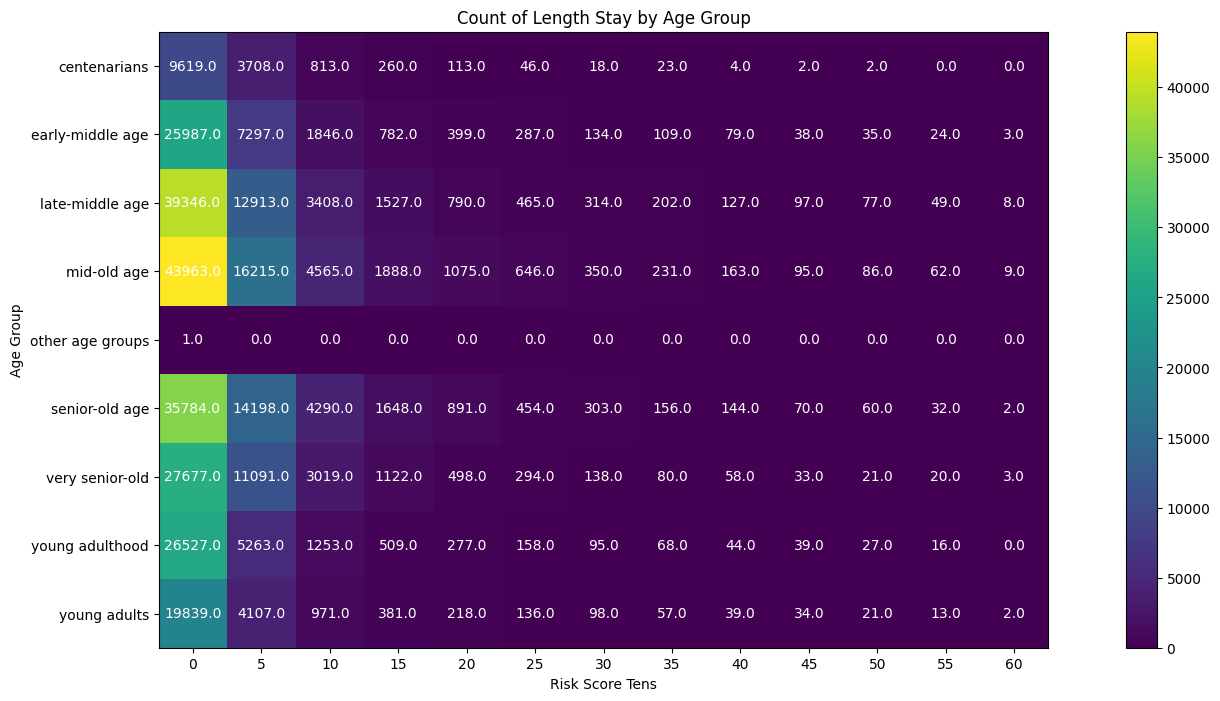

In [4]:
df = gold_encounter_df[(gold_encounter_df['stayLength']> 0) & (gold_encounter_df['stayLength'] <= 60)]
df['scoreTens'] = df['stayLength'] // 5 * 5

grouped_df = df.groupby(['ageGroup', 'scoreTens']).size().reset_index(name='count')

pivot_df = grouped_df.pivot_table(index='ageGroup', columns='scoreTens', values='count', fill_value=0)

plt.figure(figsize=(20, 8))
plt.imshow(pivot_df, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.xlabel('Risk Score Tens')
plt.ylabel('Age Group')
plt.title('Count of Length Stay by Age Group')
plt.colorbar()

for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        plt.text(j, i, str(pivot_df.values[i, j]), ha='center', va='center', color='w')

plt.show()

## Outliers

In [5]:
gold_encounter_df

,gender,ageGroup,maritalStatus,stayLength,encounterClass,admitSource,priority,riskScore,highRiskCondition,moderateRiskCondition,lowRiskCondition,readmissionStatus
0,female,mid-old age,Divorced,0,Emergency,AMBULANCE,emergency,0,0,0,0,Readmission
1,female,early-middle age,Married,0,Emergency,WALK IN,emergency,0,0,0,0,No Readmission
2,female,young adulthood,Married,4,Ambulatory,PHYSICIAN REFERRAL,urgent,0,0,0,0,No Readmission
3,female,very senior-old,Married,1,Emergency,EMERGENCY ROOM,emergency,1,0,0,1,No Readmission
4,female,young adults,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,No Readmission
...,...,...,...,...,...,...,...,...,...,...,...,...
856313,female,early-middle age,Never Married,51,Emergency,EMERGENCY ROOM,emergency,0,0,0,0,No Readmission
856314,male,young adults,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,No Readmission
856315,male,young adulthood,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,No Readmission
856316,male,mid-old age,Married,0,Emergency,AMBULANCE,emergency,0,0,0,0,No Readmission


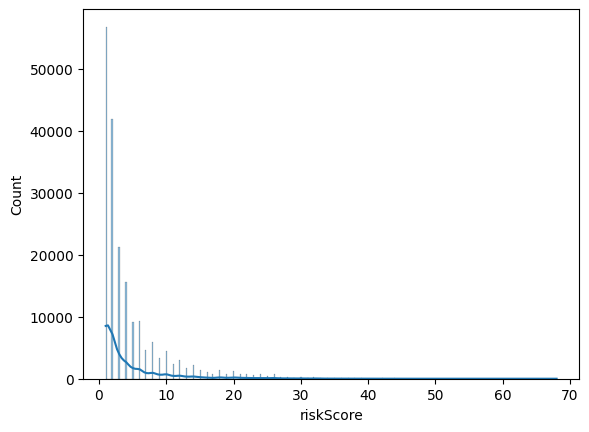

In [21]:
sns.histplot(gold_encounter_df[gold_encounter_df['riskScore']>0]['riskScore'], kde=True)
plt.show()

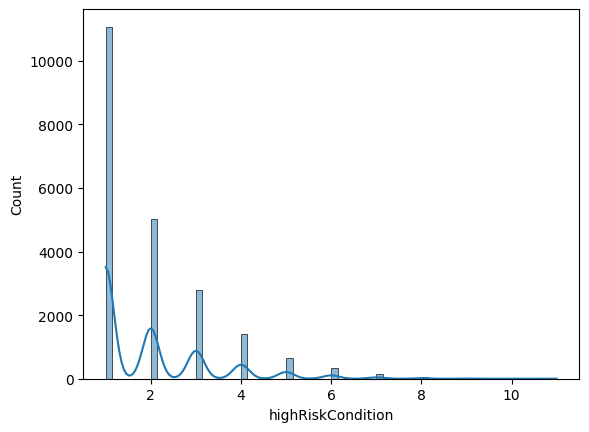

In [22]:
sns.histplot(gold_encounter_df[gold_encounter_df['highRiskCondition']>0]['highRiskCondition'], kde=True)
plt.show()

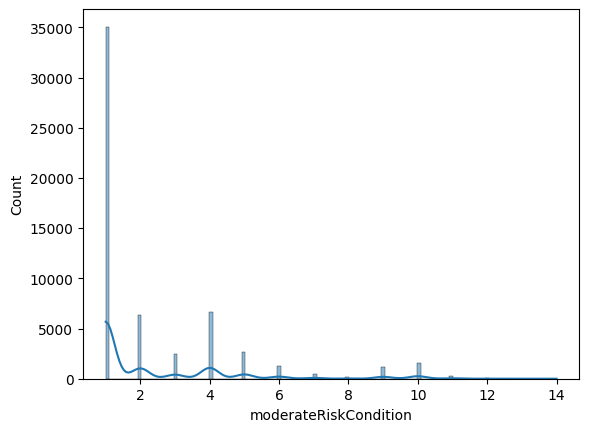

In [23]:
sns.histplot(gold_encounter_df[gold_encounter_df['moderateRiskCondition']>0]['moderateRiskCondition'], kde=True)
plt.show()

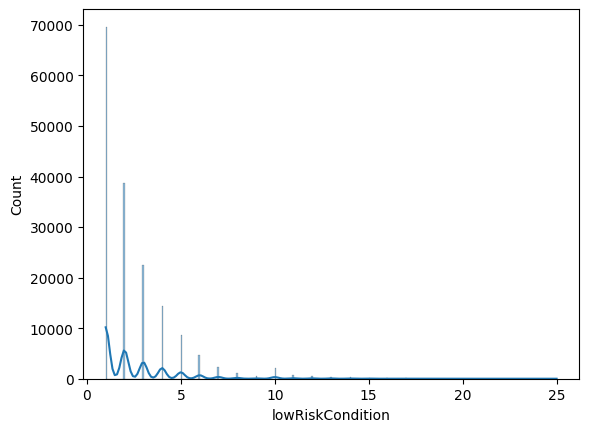

In [24]:
sns.histplot(gold_encounter_df[gold_encounter_df['lowRiskCondition']>0]['lowRiskCondition'], kde=True)
plt.show()

# 06. Data Preprocessing

In [5]:
# pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [6]:
gold_encounter_df['readmissionStatus'] = gold_encounter_df['readmissionStatus'].map({'Readmission': 1, 'No Readmission': 0})
gold_encounter_df

,gender,ageGroup,maritalStatus,stayLength,encounterClass,admitSource,priority,riskScore,highRiskCondition,moderateRiskCondition,lowRiskCondition,readmissionStatus,year
0,female,mid-old age,Divorced,0,Emergency,AMBULANCE,emergency,0,0,0,0,1,2150
1,female,early-middle age,Married,0,Emergency,WALK IN,emergency,0,0,0,0,0,2152
2,female,young adulthood,Married,4,Ambulatory,PHYSICIAN REFERRAL,urgent,0,0,0,0,0,2147
3,female,very senior-old,Married,1,Emergency,EMERGENCY ROOM,emergency,1,0,0,1,0,2181
4,female,young adults,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,0,2152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
856313,female,early-middle age,Never Married,51,Emergency,EMERGENCY ROOM,emergency,0,0,0,0,0,2157
856314,male,young adults,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,0,2184
856315,male,young adulthood,Unknown,0,Emergency,WALK IN,emergency,0,0,0,0,0,2177
856316,male,mid-old age,Married,0,Emergency,AMBULANCE,emergency,0,0,0,0,0,2133


## One-Hot Encoding

- Encoding categorical variables converts categorical variables (text labels) into numerical values (integer labels).
- Many machine learning algorithms expect numerical input. Categorical variables, which represent groups or categories (e.g., "red," "blue," "green"), cannot be directly used by these algorithms.
- **How it works**: For each category within a feature, a new binary column is created. A "1" is placed in the corresponding column for a specific data point if that category applies, and "0" otherwise.

Why One-Hot Encoding over Label Encoding:
- Avoids Implicit Ordinal Relationships (No Implicit Ranking)
- Interpretability

In [7]:
categorical_columns = ['gender','ageGroup','maritalStatus','encounterClass','admitSource','priority']
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(gold_encounter_df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

target_df = pd.concat([gold_encounter_df, one_hot_df], axis=1)
target_df = target_df.drop(categorical_columns, axis=1)
target_df

,stayLength,riskScore,highRiskCondition,moderateRiskCondition,lowRiskCondition,readmissionStatus,year,gender_female,gender_male,ageGroup_centenarians,...,admitSource_PROCEDURE SITE,admitSource_TRANSFER FROM HOSPITAL,admitSource_TRANSFER FROM SKILLED NURSING FACILITY,admitSource_UNKNOWN,admitSource_WALK IN,admitSource_WALK-IN/SELF REFERRAL,priority_elective,priority_emergency,priority_routine,priority_urgent
0,0,0,0,0,0,1,2150,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,0,0,0,0,0,2152,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,4,0,0,0,0,0,2147,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,0,0,1,0,2181,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,0,0,0,0,2152,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856313,51,0,0,0,0,0,2157,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
856314,0,0,0,0,0,0,2184,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
856315,0,0,0,0,0,0,2177,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
856316,0,0,0,0,0,0,2133,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Oversampling the Minority Class

In [8]:
X = target_df.drop(columns=['readmissionStatus'])
y = target_df['readmissionStatus']

print("Class distribution before oversampling:")
print(Counter(y))

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(Counter(y_resampled))

Class distribution before oversampling:
Counter({0: 519820, 1: 336498})
Class distribution after oversampling:
Counter({1: 519820, 0: 519820})


## Scaling Numerical Features

- Ensures all numerical features in a dataset are on a similar scale.
- Many machine learning algorithms are sensitive to the scale of the input features, particularly distance-based algorithms like k-Nearest Neighbors (k-NN) and gradient descent-based algorithms.
- Features with larger scales can dominate the learning process, leading to biased models. Scaling ensures that all features contribute equally to the model's learning.

In [9]:
cols_to_scale = ['stayLength', 'riskScore', 'highRiskCondition', 'moderateRiskCondition', 'lowRiskCondition'] 

scaler = StandardScaler()
X_resampled[cols_to_scale] = scaler.fit_transform(X_resampled[cols_to_scale])

X_resampled

,stayLength,riskScore,highRiskCondition,moderateRiskCondition,lowRiskCondition,year,gender_female,gender_male,ageGroup_centenarians,ageGroup_early-middle age,...,admitSource_PROCEDURE SITE,admitSource_TRANSFER FROM HOSPITAL,admitSource_TRANSFER FROM SKILLED NURSING FACILITY,admitSource_UNKNOWN,admitSource_WALK IN,admitSource_WALK-IN/SELF REFERRAL,priority_elective,priority_emergency,priority_routine,priority_urgent
0,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2150,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2152,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.424648,-0.312267,-0.130848,-0.187351,-0.345764,2147,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.176465,-0.013483,-0.130848,-0.187351,0.380201,2181,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2152,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039635,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2143,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1039636,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2173,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1039637,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2186,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1039638,-0.376836,-0.312267,-0.130848,-0.187351,-0.345764,2176,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Pearson Correlation Coefficient

> Moderate positive correlation between `risk score` and `risk conditions`

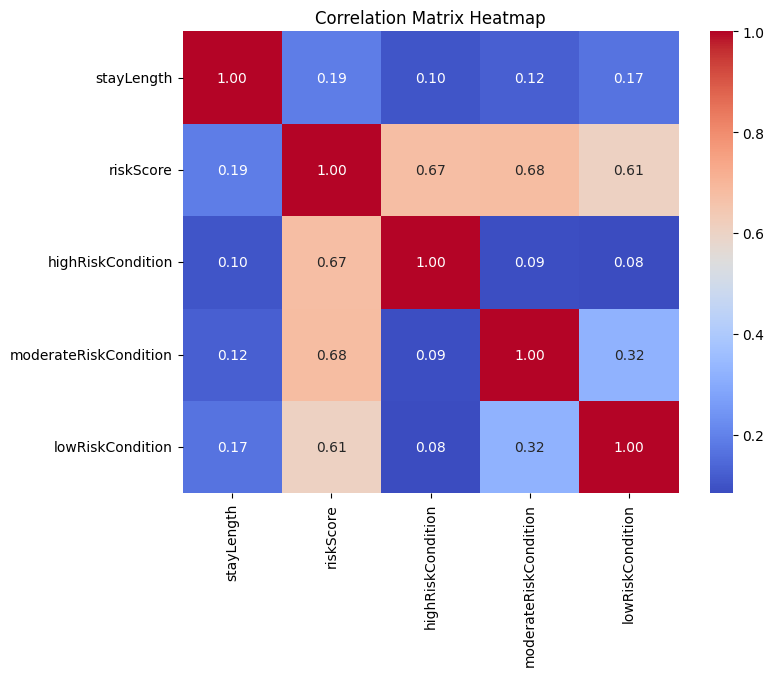

In [10]:
df = X_resampled[["stayLength","riskScore","highRiskCondition","moderateRiskCondition","lowRiskCondition"]]
correlation_matrix = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## Split Training & Testing Dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=20
)

# 07. Model Training

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [14]:
model_metrics = {}
def calculate_score(model):
    y_pred = model.predict(X_test)
    score = {
        "accuracy_score": accuracy_score(y_test, y_pred),
        "precision_score": precision_score(y_test, y_pred),
        "recall_score": recall_score(y_test, y_pred),
        "roc_auc_score": roc_auc_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
    }
    print("Accuracy:", "{:.2f}%".format(score['accuracy_score']*100))
    print("Precision:", "{:.2f}%".format(score['precision_score']*100))
    print("Recall:", "{:.2f}%".format(score['recall_score']*100))
    print("F1 Score:", "{:.2f}%".format(score['f1_score']*100))
    print("Area Under the Curve:", "{:.2f}%".format(score['roc_auc_score']*100))

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-"*50)
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Readmission', 'Readmission'])
    # Generate ROC curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Plot confusion matrix on the first subplot
    cm_display.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    # Plot ROC curve on the second subplot
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    plt.tight_layout()
    plt.show()
    return score

## Logistic Regression

- Logistic regression is a straightforward model that provides coefficients that can be directly interpreted.
- **Baseline Performance**: It serves as a benchmark for other, more complex models. It allows you to understand how well a simple model performs before moving on to more complex ones.
- **Computational Efficiency**: Logistic regression is computationally inexpensive and fast, making it suitable when working with smaller datasets or when quick results are needed.

Accuracy: 74.26%
Precision: 76.45%
Recall: 70.17%
F1 Score: 73.17%
Area Under the Curve: 74.26%
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75    103883
           1       0.76      0.70      0.73    104045

    accuracy                           0.74    207928
   macro avg       0.74      0.74      0.74    207928
weighted avg       0.74      0.74      0.74    207928

--------------------------------------------------


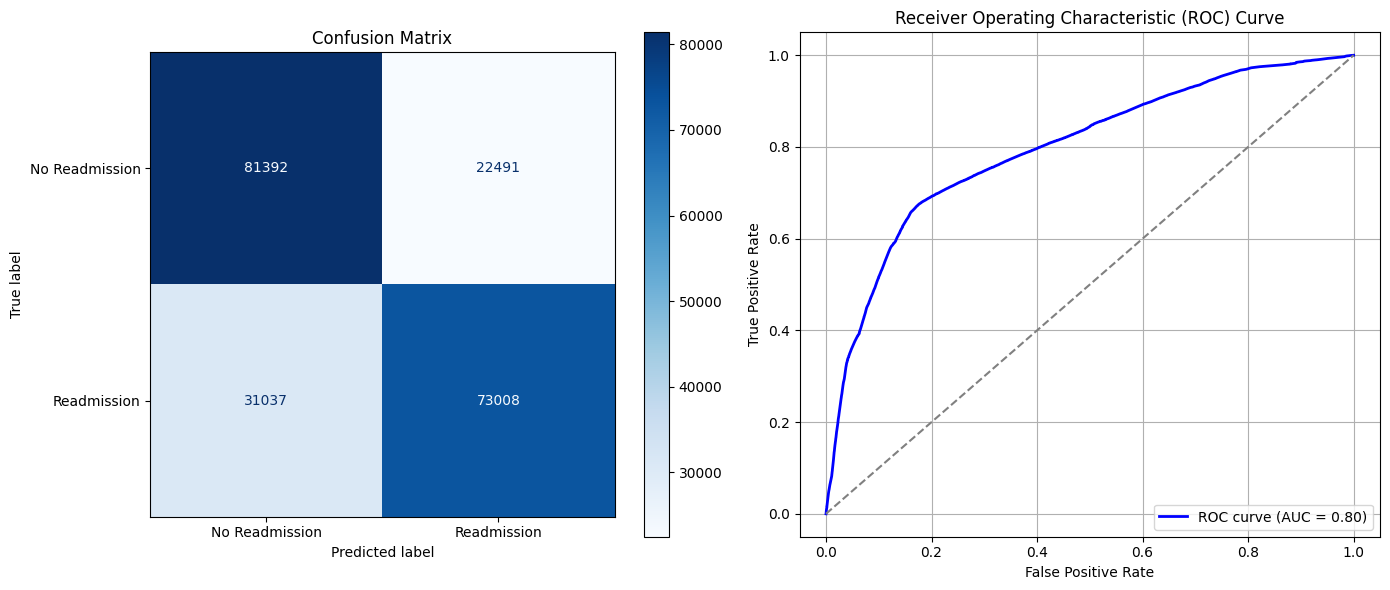

In [15]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

model_metrics['Logistic Regression'] = calculate_score(logreg)

<!-- ## Logistic Regression CV -->

## Logistic Regression CV

- Best parameters found: `{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 100}`
- Best cross-validation score: `0.7724556802725655`

<!-- ```output
Best parameters found: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 100}
Best cross-validation score: 0.7724556802725655
Accuracy: 77.10%
Precision: 82.58%
Recall: 66.78%
F1 Score: 73.84%
Area Under the Curve: 76.78%
Classification Report:
               precision    recall  f1-score   support
           0       0.74      0.87      0.80      2551
           1       0.83      0.67      0.74      2393
    accuracy                           0.77      4944
   macro avg       0.78      0.77      0.77      4944
weighted avg       0.78      0.77      0.77      4944
``` -->

In [16]:
# param_dist = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'solver': ['liblinear', 'saga', 'lbfgs'],  # Common solvers for Logistic Regression
#     'penalty': ['l1', 'l2', 'elasticnet'],     # Penalty types (saga supports elasticnet)
#     'max_iter': [100, 200, 300]           # Maximum number of iterations
# }

# logreg = LogisticRegression()
# random_search = RandomizedSearchCV(
#     estimator=logreg,  
#     param_distributions=param_dist,
#     n_iter=50,  # Number of parameter settings sampled
#     cv=5,       # 5-fold cross-validation
#     scoring='accuracy',  # Evaluation metric
#     random_state=42,     # For reproducibility
#     n_jobs=-1            # Use all available CPU cores
# )

# random_search.fit(X_train, y_train)
# print(f"Best parameters found: {random_search.best_params_}")
# print(f"Best cross-validation score: {random_search.best_score_}")

# best_logreg = random_search.best_estimator_
# model_metrics['Logistic Regression CV'] = calculate_score(best_logreg)

## K-Nearest Neighbors

Accuracy: 74.18%
Precision: 73.48%
Recall: 75.73%
F1 Score: 74.59%
Area Under the Curve: 74.18%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74    103883
           1       0.73      0.76      0.75    104045

    accuracy                           0.74    207928
   macro avg       0.74      0.74      0.74    207928
weighted avg       0.74      0.74      0.74    207928

--------------------------------------------------


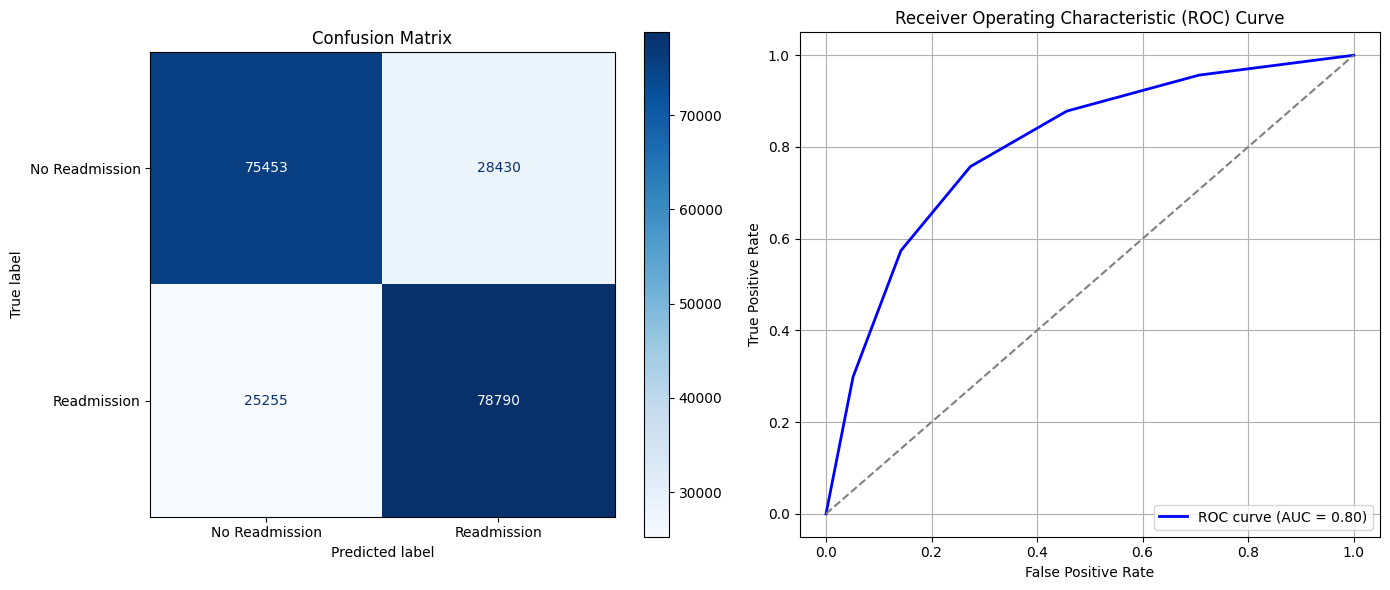

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
model_metrics['KNN'] = calculate_score(knn_model)

## Decision Tree

Accuracy: 75.73%
Precision: 73.85%
Recall: 79.73%
F1 Score: 76.67%
Area Under the Curve: 75.72%
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75    103883
           1       0.74      0.80      0.77    104045

    accuracy                           0.76    207928
   macro avg       0.76      0.76      0.76    207928
weighted avg       0.76      0.76      0.76    207928

--------------------------------------------------


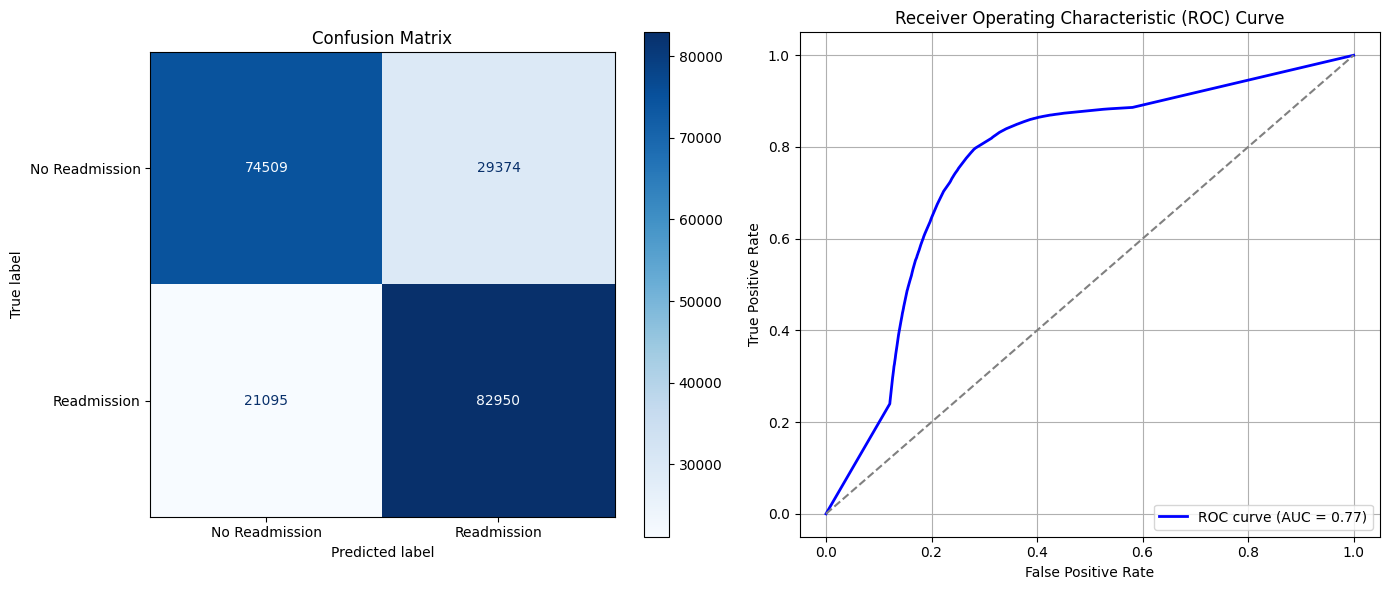

In [18]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
model_metrics['Decision Tree'] = calculate_score(dt_model)

In [19]:
scores = cross_val_score(dt_model, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')

Cross-Validation Accuracy Scores: [0.72468236 0.72394666 0.7268778  0.72639157 0.72508948]
Mean Accuracy: 0.7253975750666286


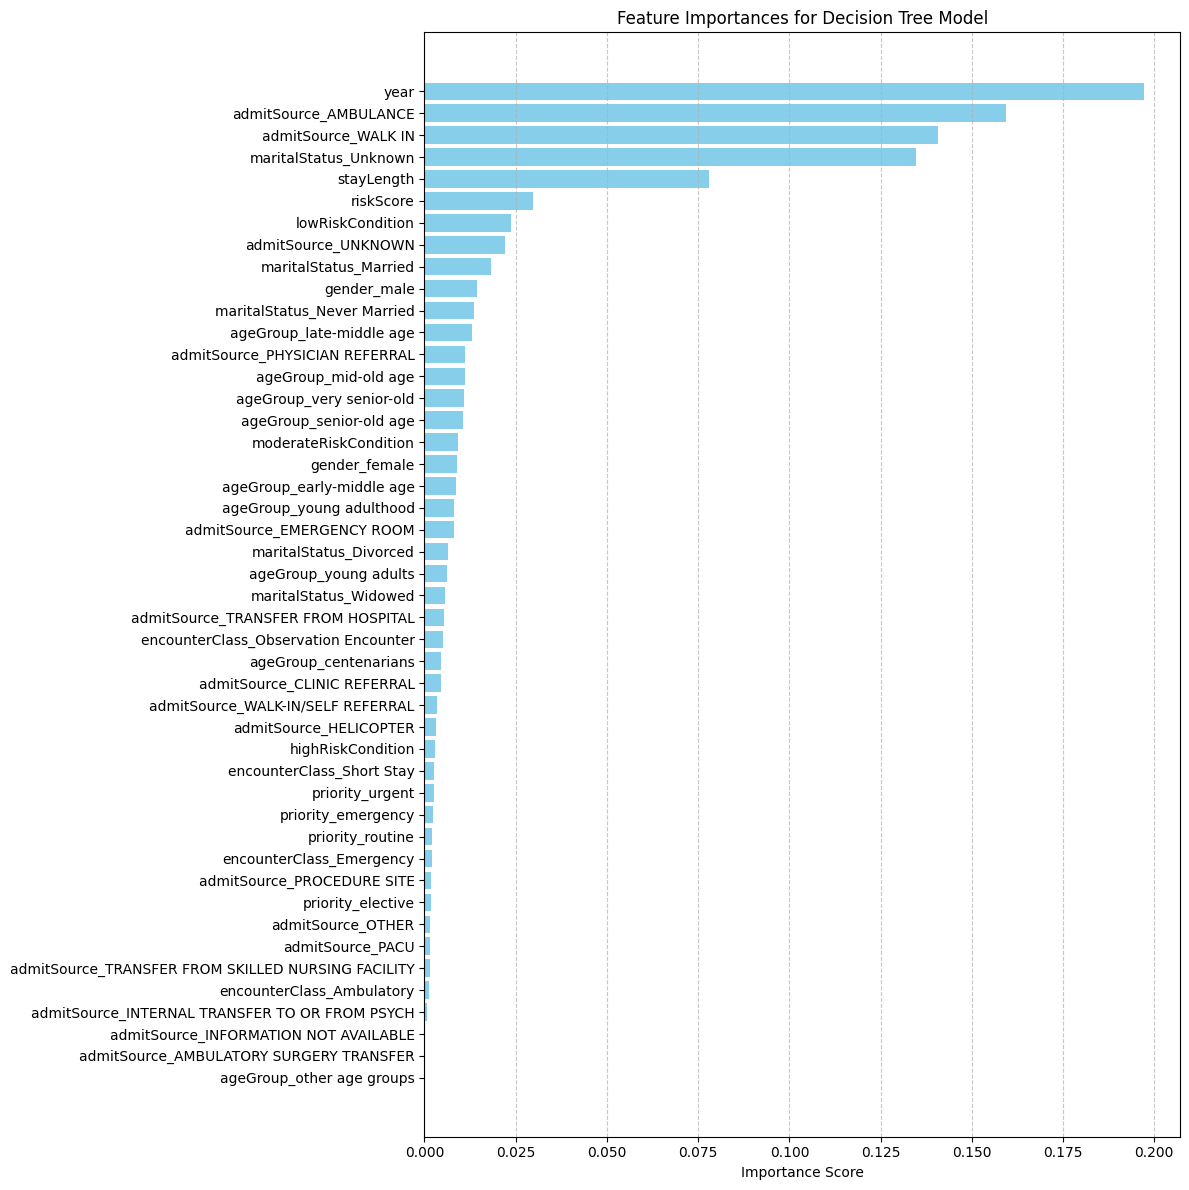

In [20]:
# Get feature importances from the model
feature_importances = dt_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances for Decision Tree Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Decision Tree CV

- Best Parameters: `{'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(5), 'max_depth': 20, 'criterion': 'entropy'}`
- Best cross-validation score: `0.8030545073656787`

<!-- ```output
Best Parameters: {'min_samples_split': np.int64(14), 'min_samples_leaf': np.int64(5), 'max_depth': 20, 'criterion': 'entropy'}
Best cross-validation score: 0.8030545073656787
Accuracy: 79.77%
Precision: 80.16%
Recall: 77.35%
F1 Score: 78.73%
Area Under the Curve: 79.70%
Classification Report:
               precision    recall  f1-score   support
           0       0.79      0.82      0.81      2551
           1       0.80      0.77      0.79      2393
    accuracy                           0.80      4944
   macro avg       0.80      0.80      0.80      4944
weighted avg       0.80      0.80      0.80      4944
``` -->

In [21]:
# param_grid = {
#     'max_depth': [3, 5, 10, 20, None],
#     'min_samples_split': np.arange(2, 21, 2),
#     'min_samples_leaf': np.arange(1, 21, 2),
#     'criterion': ['gini', 'entropy']
# }

# dt_model = DecisionTreeClassifier(random_state=42)

# random_search = RandomizedSearchCV(
#     estimator=dt_model,
#     param_distributions=param_grid,
#     n_iter=100,  # Number of parameter combinations to try
#     scoring='accuracy',
#     cv=5,  # 5-fold cross-validation
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best cross-validation score: {random_search.best_score_}")
# best_dt_model = random_search.best_estimator_
# model_metrics['Decision Tree CV'] = calculate_score(best_dt_model)

## Random Forest

Accuracy: 77.22%
Precision: 75.87%
Recall: 79.89%
F1 Score: 77.83%
Area Under the Curve: 77.22%
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    103883
           1       0.76      0.80      0.78    104045

    accuracy                           0.77    207928
   macro avg       0.77      0.77      0.77    207928
weighted avg       0.77      0.77      0.77    207928

--------------------------------------------------


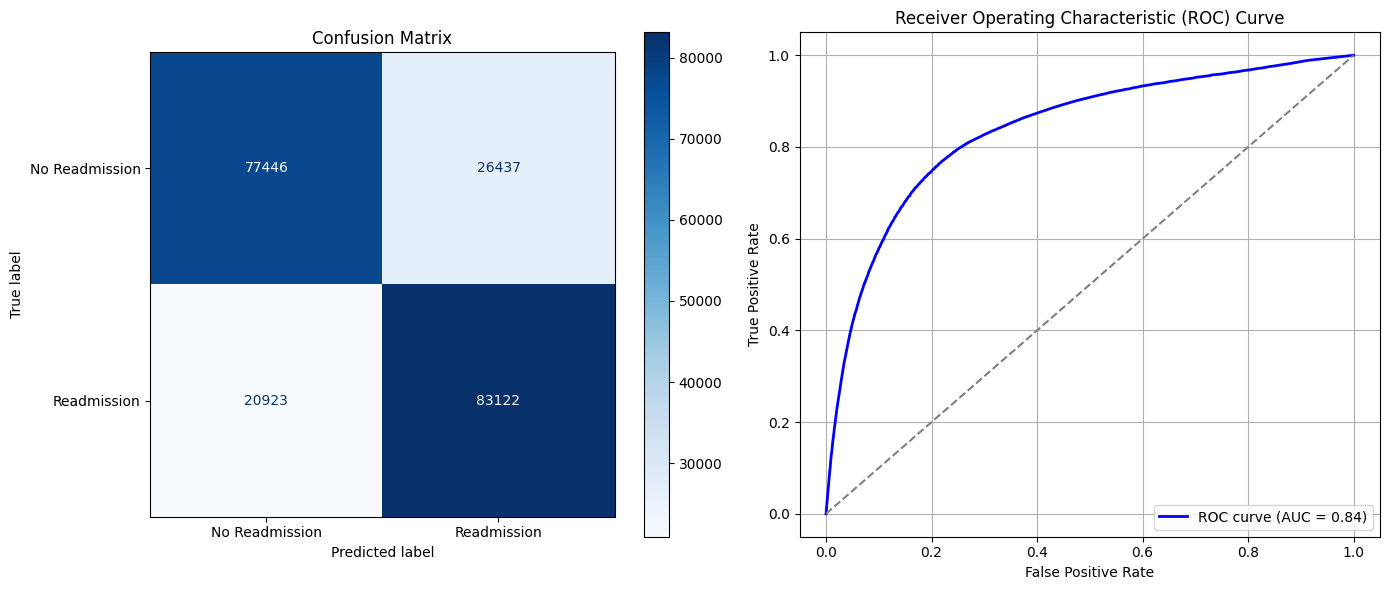

In [22]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
model_metrics['Random Forest'] = calculate_score(rf_model)

In [23]:
scores = cross_val_score(rf_model, X_test, y_test, scoring="accuracy", cv=5, verbose=True)
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')

Cross-Validation Accuracy Scores: [0.75349877 0.75345068 0.75412398 0.75012625 0.75257905]
Mean Accuracy: 0.7527557481137999


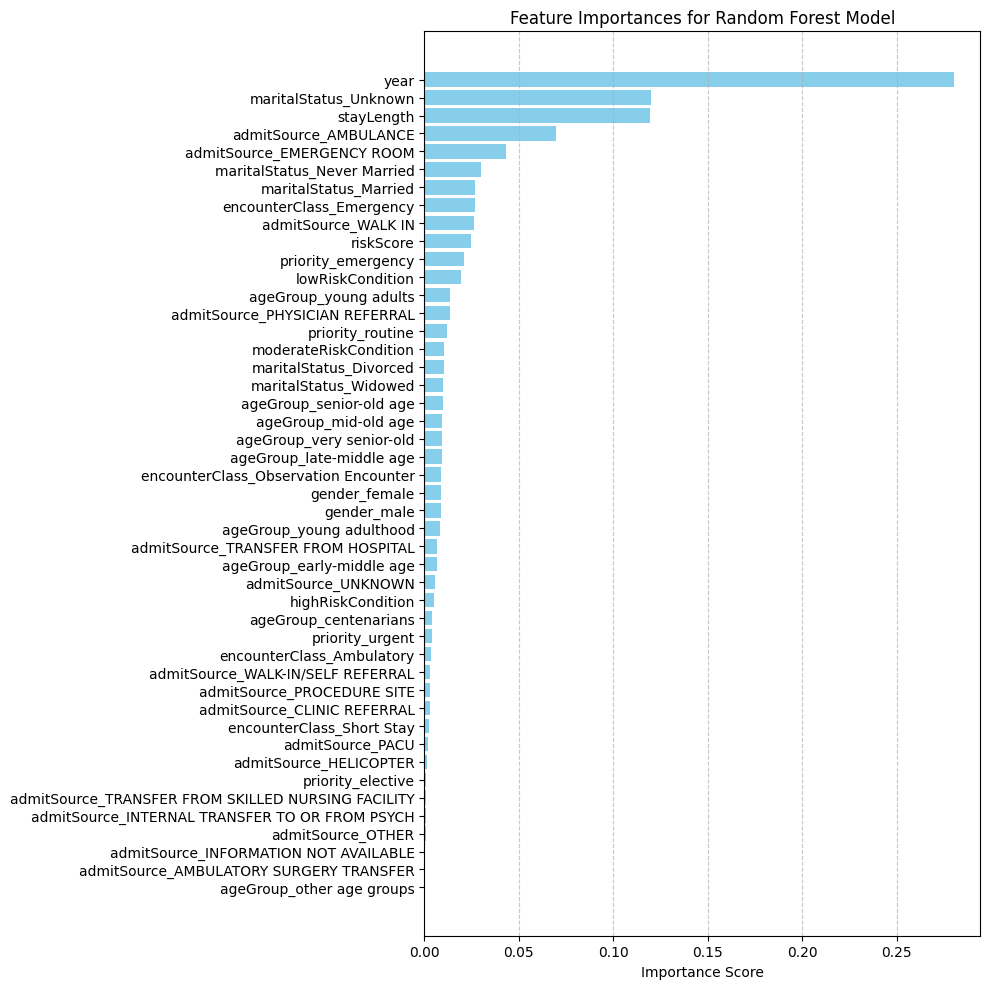

In [24]:
# Get feature importances from the model
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances for Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Random Forest CV

- Best Parameters: `{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}`
- Best cross-validation score: `0.8231334557269534`

<!-- ```output
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best cross-validation score: 0.8231334557269534
Accuracy: 82.02%
Precision: 83.66%
Recall: 78.10%
F1 Score: 80.79%
Area Under the Curve: 81.90%
Classification Report:
               precision    recall  f1-score   support
           0       0.81      0.86      0.83      2551
           1       0.84      0.78      0.81      2393
    accuracy                           0.82      4944
   macro avg       0.82      0.82      0.82      4944
weighted avg       0.82      0.82      0.82      4944
``` -->

In [25]:
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# rf_model = RandomForestClassifier(random_state=42)
# random_search = RandomizedSearchCV(
#     estimator=rf_model,
#     param_distributions=param_grid,
#     n_iter=100,
#     cv=5,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best cross-validation score: {random_search.best_score_}")

# best_rf_model = random_search.best_estimator_
# model_metrics['Random Forest CV'] = calculate_score(best_rf_model)

## Gradient Boosting

Accuracy: 78.00%
Precision: 81.24%
Recall: 72.87%
F1 Score: 76.82%
Area Under the Curve: 78.01%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79    103883
           1       0.81      0.73      0.77    104045

    accuracy                           0.78    207928
   macro avg       0.78      0.78      0.78    207928
weighted avg       0.78      0.78      0.78    207928

--------------------------------------------------


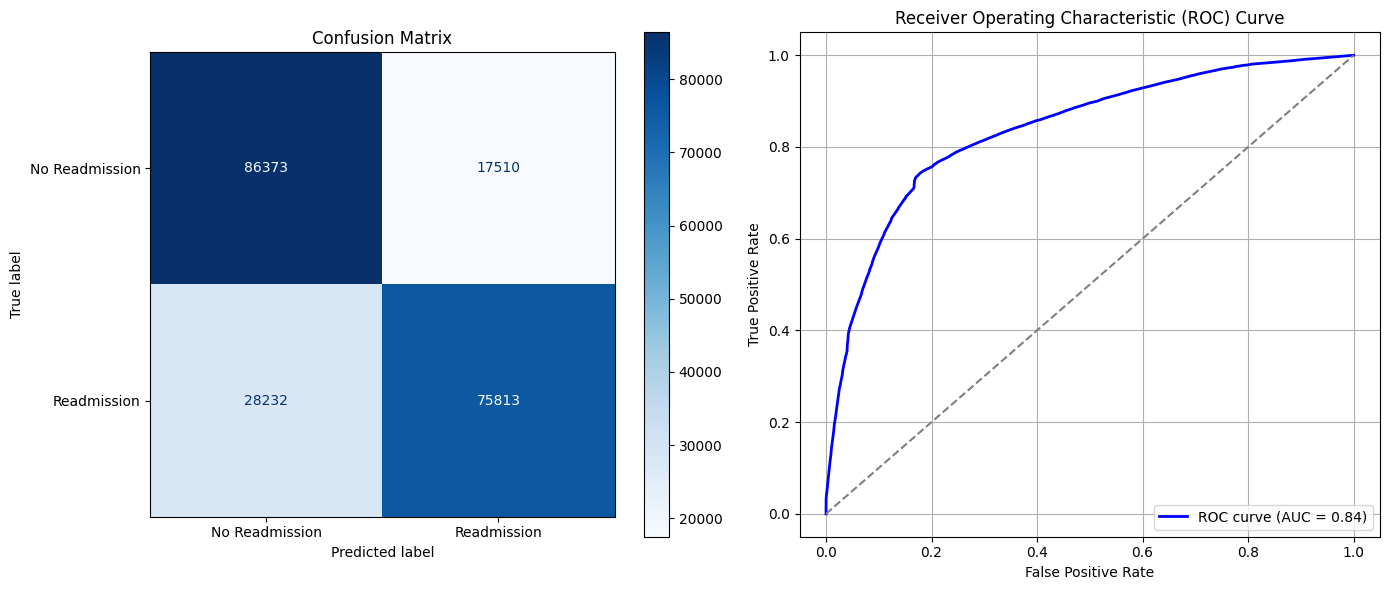

In [26]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

model_metrics['Gradient Boosting'] = calculate_score(gbc)

## Gradient Boosting CV

- Best Parameters: `{'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}`
- Best cross-validation score: `0.8266233050126525`

<!-- ```output
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'learning_rate': 0.05}
Best cross-validation score: 0.8266233050126525
Accuracy: 82.40%
Precision: 85.44%
Recall: 76.72%
F1 Score: 80.85%
Area Under the Curve: 82.23%
Classification Report:
               precision    recall  f1-score   support
           0       0.80      0.88      0.84      2551
           1       0.85      0.77      0.81      2393
    accuracy                           0.82      4944
   macro avg       0.83      0.82      0.82      4944
weighted avg       0.83      0.82      0.82      4944
``` -->

In [27]:
# # Define the parameter grid with reasonable default values
# param_dist = {
#     'n_estimators': [50, 100, 150, 200],          # Number of boosting rounds
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Learning rate
#     'max_depth': [3, 5, 7, 10],                    # Maximum depth of trees
#     'min_samples_split': [2, 5, 10, 20],            # Minimum samples required to split a node
#     'min_samples_leaf': [1, 2, 5, 10],              # Minimum samples required to be at a leaf node
#     'subsample': [0.7, 0.8, 0.9, 1.0]             # Fraction of samples used for fitting each tree
# }
# gbm = GradientBoostingClassifier()
# random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, 
#                                    n_iter=50, cv=3, verbose=1, 
#                                    random_state=42, n_jobs=-1)
# random_search.fit(X_train, y_train)

# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best cross-validation score: {random_search.best_score_}")

# best_gbm_model = random_search.best_estimator_
# model_metrics['Gradient Boosting CV'] = calculate_score(best_gbm_model)

## LightGBM

In [28]:
# !pip install lightgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 415775, number of negative: 415937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7677
[LightGBM] [Info] Number of data points in the train set: 831712, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499903 -> initscore=-0.000390
[LightGBM] [Info] Start training from score -0.000390
Accuracy: 78.81%
Precision: 81.34%
Recall: 74.82%
F1 Score: 77.94%
Area Under the Curve: 78.81%
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80    103883
           1       0.81      0.75      0.78    104045

    accuracy                           0.79    207928
   macro avg       0.

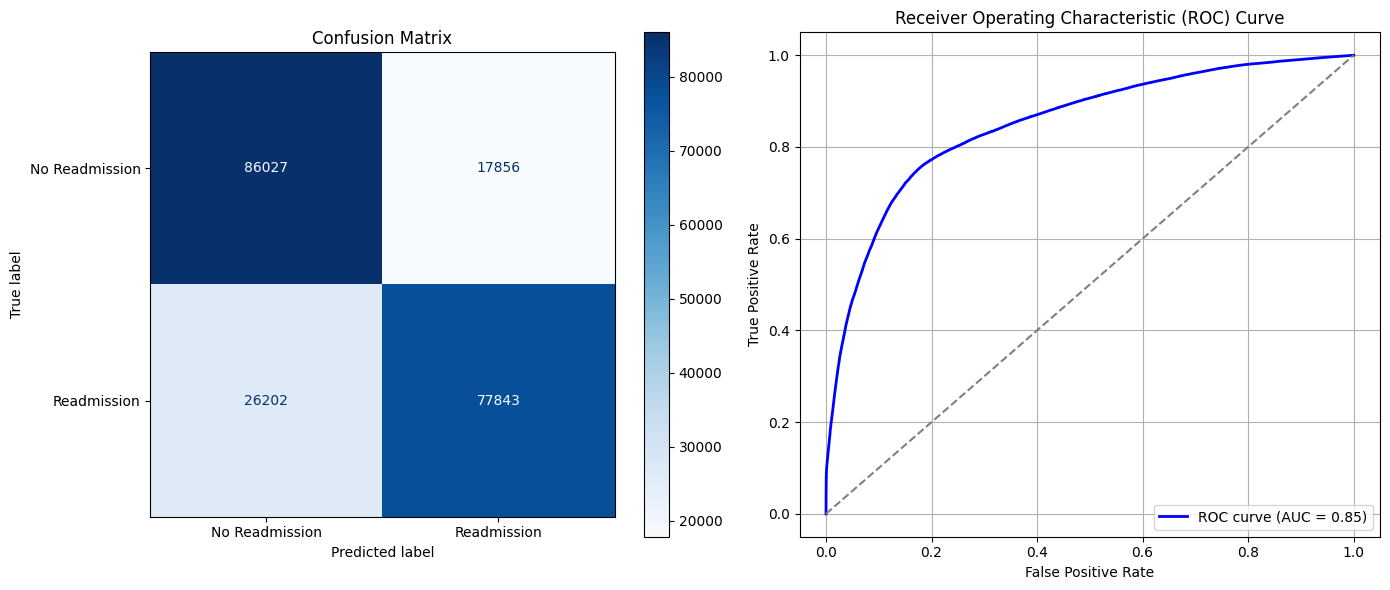

In [29]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,     # Number of boosting rounds
    learning_rate=0.1,    # Step size shrinkage
    max_depth=-1,         # No limit on tree depth (can be tuned)
    random_state=42
)
lgb_model.fit(X_train, y_train)
model_metrics['LightGBM'] = calculate_score(lgb_model)

## LightGBM CV

- Best Parameters: `{'subsample': 0.8, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.6}`
- Best cross-validation score: `0.8801788146401774`

<!-- ```output
Best Parameters: {'subsample': 0.8, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best cross-validation score: 0.8801788146401774
Accuracy: 82.61%
Precision: 85.67%
Recall: 76.93%
F1 Score: 81.07%
Area Under the Curve: 82.43%
Classification Report:
               precision    recall  f1-score   support
           0       0.80      0.88      0.84      2551
           1       0.86      0.77      0.81      2393
    accuracy                           0.83      4944
   macro avg       0.83      0.82      0.82      4944
weighted avg       0.83      0.83      0.83      4944
``` -->

In [30]:
# lgbm = lgb.LGBMClassifier(random_state=42)
# param_grid = {
#     'num_leaves': [20, 31, 40, 50],
#     'max_depth': [-1, 10, 20, 30],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_child_samples': [5, 10, 20, 30],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# random_search = RandomizedSearchCV(
#     estimator=lgbm, 
#     param_distributions=param_grid, 
#     n_iter=50,  # Number of parameter settings sampled
#     scoring='roc_auc',  # Metric to optimize
#     cv=3,  # Number of cross-validation folds
#     verbose=1, 
#     random_state=42, 
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print(f"Best Parameters: {random_search.best_params_}")
# print(f"Best cross-validation score: {random_search.best_score_}")
# best_lightgbm_model = random_search.best_estimator_
# model_metrics['LightGBM CV'] = calculate_score(best_lightgbm_model)

# 08. Model Evaluation

<!-- ```python
model_metrics = {'Logistic Regression': {'accuracy_score': 0.7554611650485437,
  'precision_score': 0.7916256157635468,
  'recall_score': 0.671541997492687,
  'roc_auc_score': np.float64(0.7528623354770374),
  'f1_score': 0.726656115758535},
 'Logistic Regression CV': {'accuracy_score': 0.7710355987055016,
  'precision_score': 0.8258397932816538,
  'recall_score': 0.6677810279983285,
  'roc_auc_score': np.float64(0.7678379855789369),
  'f1_score': 0.7384473197781886},
 'KNN': {'accuracy_score': 0.7702265372168284,
  'precision_score': 0.7487138899881283,
  'recall_score': 0.790639364814041,
  'roc_auc_score': np.float64(0.7708586867190549),
  'f1_score': 0.7691056910569106},
 'Decision Tree': {'accuracy_score': 0.7874190938511327,
  'precision_score': 0.7716599190283401,
  'recall_score': 0.7964897618052653,
  'roc_auc_score': np.float64(0.7876999965435577),
  'f1_score': 0.7838782644458153},
 'Decision Tree CV': {'accuracy_score': 0.7977346278317152,
  'precision_score': 0.8016457340840191,
  'recall_score': 0.7735060593397409,
  'roc_auc_score': np.float64(0.7969843115201253),
  'f1_score': 0.7873245427477669},
 'Random Forest': {'accuracy_score': 0.8131067961165048,
  'precision_score': 0.8071936428272689,
  'recall_score': 0.8065190137902215,
  'roc_auc_score': np.float64(0.812902784041328),
  'f1_score': 0.8068561872909699},
 'Random Forest CV': {'accuracy_score': 0.8201860841423948,
  'precision_score': 0.8366159355416294,
  'recall_score': 0.781027998328458,
  'roc_auc_score': np.float64(0.8189734268396504),
  'f1_score': 0.8078668683812406},
 'Gradient Boosting': {'accuracy_score': 0.8092637540453075,
  'precision_score': 0.8632264529058116,
  'recall_score': 0.7200167154199749,
  'roc_auc_score': np.float64(0.8064999296425629),
  'f1_score': 0.785144679881522},
 'Gradient Boosting CV': {'accuracy_score': 0.8240291262135923,
  'precision_score': 0.8543508608655188,
  'recall_score': 0.7672377768491433,
  'roc_auc_score': np.float64(0.8222703976366453),
  'f1_score': 0.808454425363276},
 'LightGBM': {'accuracy_score': 0.8262540453074434,
  'precision_score': 0.8590823970037453,
  'recall_score': 0.7668198913497701,
  'roc_auc_score': np.float64(0.8244134737031094),
  'f1_score': 0.8103334069330979},
 'LightGBM CV': {'accuracy_score': 0.8260517799352751,
  'precision_score': 0.8566775244299675,
  'recall_score': 0.7693272043460092,
  'roc_auc_score': np.float64(0.824295119225141),
  'f1_score': 0.8106560986349626}}
``` -->

,Logistic Regression,KNN,Decision Tree,Random Forest,Gradient Boosting,LightGBM
accuracy_score,0.742565,0.741810,0.757277,0.772229,0.780010,0.788109
precision_score,0.764490,0.734844,0.738489,0.758696,0.812372,0.813415
recall_score,0.701696,0.757268,0.797251,0.798904,0.728656,0.748167
roc_auc_score,0.742597,0.741798,0.757245,0.772208,0.780050,0.788140
f1_score,0.731748,0.745888,0.766746,0.778281,0.768240,0.779428


<Axes: >

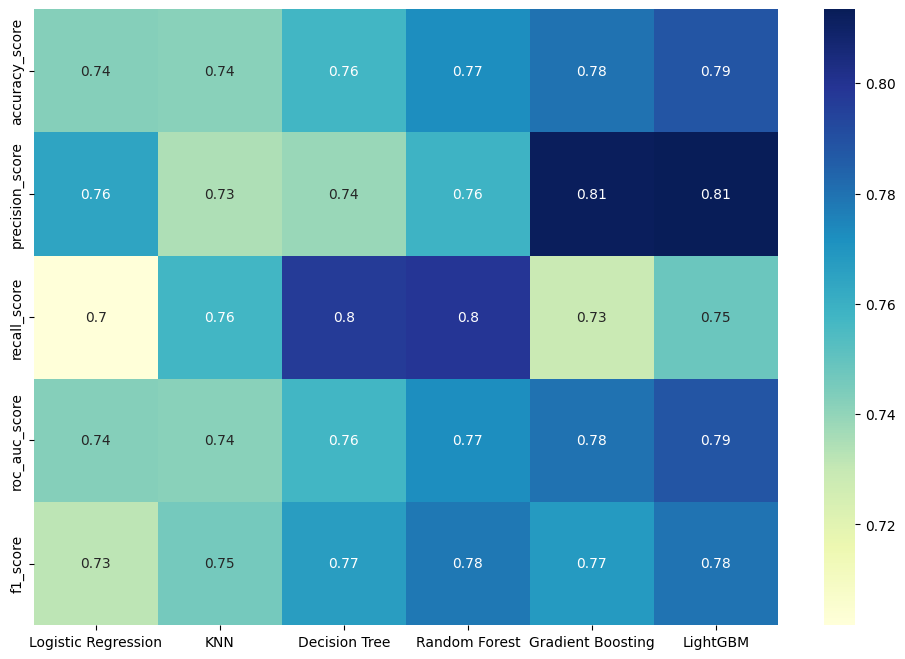

In [31]:
df = pd.DataFrame(model_metrics)
plt.figure(figsize=(12, 8))
display(df)
sns.heatmap(df, annot=True, cmap='YlGnBu', cbar=True)

# 09. Model Deployment

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel

import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder \
    .appName("FhirDataApplication") \
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.5.2") \
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
    .config("spark.sql.catalog.local", "org.apache.iceberg.spark.SparkCatalog") \
    .config("spark.sql.catalog.local.type", "hadoop") \
    .config("spark.sql.catalog.local.warehouse", "dataset/iceberg") \
    .getOrCreate()

In [ ]:
gold_encounter_df = spark.read.format("iceberg").load("local.gold.encounter")
gold_encounter_df = gold_encounter_df.withColumn(
    "readmissionStatus", F.when(F.col("readmissionStatus") == "Readmission", 1.0).otherwise(0.0)
)
train_data, test_data = gold_encounter_df.randomSplit([0.8, 0.2], seed=42)

In [2]:
categorical_columns = ['gender', 'ageGroup', 'maritalStatus', 'encounterClass', 'admitSource', 'priority']
numerical_columns = ['stayLength', 'riskScore', 'highRiskCondition', 'moderateRiskCondition', 'lowRiskCondition']

indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid="keep") for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_encoded') for col in categorical_columns]
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='numerical_features')
scaler = StandardScaler(inputCol='numerical_features', outputCol='scaled_features')
assembler_final = VectorAssembler(inputCols=[col + '_encoded' for col in categorical_columns] + ['scaled_features'], outputCol='features')

rf = RandomForestClassifier(labelCol='readmissionStatus', featuresCol='features')

# rf = RandomForestClassifier(
#     labelCol="readmissionStatus", 
#     featuresCol="features",
#     numTrees=200,                   # Equivalent to n_estimators=200
#     maxDepth=20,                    # Equivalent to max_depth=20
#     minInstancesPerNode=1,          # Equivalent to min_samples_leaf=1
#     featureSubsetStrategy="sqrt",   # Equivalent to max_features="sqrt"
#     impurity="gini"
# )

pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, assembler_final, rf])

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

original_columns = [col_item[0] for col_item in gold_encounter_df.dtypes]
original_columns.append('prediction')
predictions = predictions.select(*original_columns)
predictions.show()

In [4]:
evaluator = MulticlassClassificationEvaluator(labelCol='readmissionStatus', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 76.88%


In [6]:
# model.write().overwrite().save("dataset/rf_model")
# model = PipelineModel.load("dataset/rf_model")

Py4JJavaError: An error occurred while calling o1654.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1620)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1620)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1606)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1606)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1(Pipeline.scala:250)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.$anonfun$saveImpl$1$adapted(Pipeline.scala:247)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.Pipeline$SharedReadWrite$.saveImpl(Pipeline.scala:247)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.saveImpl(Pipeline.scala:346)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.super$save(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$4(Pipeline.scala:344)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent(events.scala:174)
	at org.apache.spark.ml.MLEvents.withSaveInstanceEvent$(events.scala:169)
	at org.apache.spark.ml.util.Instrumentation.withSaveInstanceEvent(Instrumentation.scala:42)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3(Pipeline.scala:344)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.$anonfun$save$3$adapted(Pipeline.scala:344)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.PipelineModel$PipelineModelWriter.save(Pipeline.scala:344)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 68 more


In [ ]:
# spark.sql("""
# select
#     year(encounterTs) year, readmissionStatus, count(*) count
# from local.gold.encounter
# group by 1,2
# order by 1,2
# """).show(10, truncate = False)
# spark.sql("""
# select
#     case
#         when sourceFile in ('MimicCondition.ndjson.gz', 'MimicConditionED.ndjson.gz') then replace(get_json_object(value, '$.encounter.reference'), "Encounter/", "")
#         when sourceFile in ('MimicEncounter.ndjson.gz', 'MimicEncounterICU.ndjson.gz', 'MimicEncounterED.ndjson.gz') then get_json_object(value, '$.id')
#     end as encounter_id,
#     sourcefile,
#     value
# from local.bronze.resource where sourceFile <> 'MimicPatient.ndjson.gz'
# """).show(10, truncate = False)